# QSPR Analysis

Four new topological descriptors: 
* polarisability (mordred.Polarizability)
* bond count (mordred.BondCount)
* topological index (mordred.TopologicalIndex)
* topological polar surface area descriptor (mordred.TopoPSA)

## Simple linear analysis

Loading boiling point data (102 alkenes)

In [21]:
import pandas as pd
df = pd.read_csv("102BP.csv")
df.head()

,smiles,bp_C,BP_K,MW,Name
0,C,-164.0,109.15,16.04,methane
1,CC,-88.6,184.55,30.07,ethane
2,CCC,-42.1,231.05,44.10,propane
3,CC(C)C,-11.7,261.45,58.12,2-methylpropane
4,CCCC,-0.5,272.65,58.12,butane


Importing descriptors

In [32]:
from rdkit import Chem
from mordred import Lipinski, BondCount, FragmentComplexity, SLogP

#creating descriptor instances
slogp = SLogP.SLogP()
bondcount = BondCount.BondCount()
fragcom = FragmentComplexity.FragmentComplexity()
topod = TopologicalIndex.Diameter()

Adding descriptors to the dataset

In [33]:
# create new lists to store results we calculate
result_slogp = []
result_bondcount = []
result_fragcom = []
result_topod = []

for index, row in df.iterrows():                # iterate through each row of the CSV data
    SMILE = row['smiles']                       # get SMILES string from row
    mol = Chem.MolFromSmiles(SMILE)             # convert smiles string to mol file
   
    result_slogp.append(slogp(mol))
    result_bondcount.append(bondcount(mol))
    result_fragcom.append(fragcom(mol))
    result_topod.append(topod(mol))

df['SLogP'] = result_slogp          
df['bondcount'] = result_bondcount               
df['fragcom'] = result_fragcom  
df['topod'] = result_topod 
df

,smiles,bp_C,BP_K,MW,Name,SLogP,bondcount,fragcom,topopsa,topod
0,C,-164.0,109.15,16.04,methane,0.6361,4,0.0,0,0
1,CC,-88.6,184.55,30.07,ethane,1.0262,7,1.0,1,1
2,CCC,-42.1,231.05,44.10,propane,1.4163,10,2.0,2,2
3,CC(C)C,-11.7,261.45,58.12,2-methylpropane,1.6623,13,3.0,2,2
4,CCCC,-0.5,272.65,58.12,butane,1.8064,13,3.0,3,3
...,...,...,...,...,...,...,...,...,...,...
97,CCC(C)(C)C(C)C(C)C,162.2,435.35,142.29,"2,3,4,4-tetramethylhexane",3.7147,31,9.0,5,5
98,CCC(C)C(C)CC(C)C,157.0,430.15,142.29,"2,4,5-trimethylheptane",3.7147,31,9.0,6,6
99,CCC(C)C(C)C(C)CC,164.0,437.15,142.29,"3,4,5-trimethylheptane",3.7147,31,9.0,6,6
100,CCCCC(C)C(C)CC,166.0,439.15,142.29,"3,4-dimethyloctane",3.8588,31,9.0,7,7


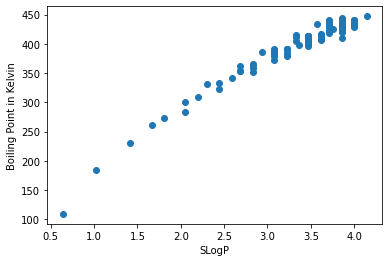

In [25]:
import matplotlib.pyplot as plt
plt.scatter(df.SLogP, df.BP_K) 
plt.xlabel('SLogP')
plt.ylabel('Boiling Point in Kelvin')
plt.show()

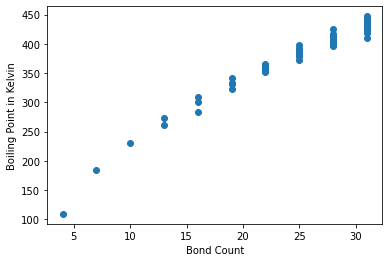

In [27]:
plt.scatter(df.bondcount, df.BP_K) 
plt.xlabel('Bond Count')
plt.ylabel('Boiling Point in Kelvin')
plt.show()

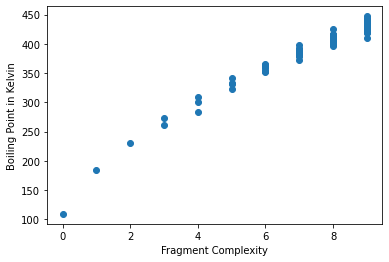

In [28]:
plt.scatter(df.fragcom, df.BP_K) 
plt.xlabel('Fragment Complexity')
plt.ylabel('Boiling Point in Kelvin')
plt.show()

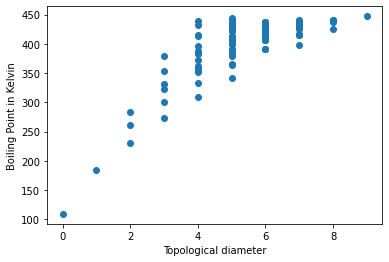

In [34]:
plt.scatter(df.topod, df.BP_K) 
plt.xlabel('Topological diameter')
plt.ylabel('Boiling Point in Kelvin')
plt.show()

##  Multiple Linear Regression

In [36]:
import statsmodels.api as sm
X = df[["SLogP","bondcount", "fragcom", "topod"]]
X = sm.add_constant(X)
Y = df[["BP_K"]]
model = sm.OLS(Y,X).fit()
predictions = model.predict(X)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   BP_K   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     874.8
Date:                Tue, 25 Aug 2020   Prob (F-statistic):           1.41e-70
Time:                        18:12:54   Log-Likelihood:                -384.46
No. Observations:                 102   AIC:                             776.9
Df Residuals:                      98   BIC:                             787.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.3154      2.653     20.847      0.0

The equation would be:

    Predicted BP = -5.5319 * SLogP + 30.5968 * bondcount - 63.5549 * fragcom + 4.2102 * topod + 55.3154

We can use this equation to predict the boiling point of a new molecule. However, before we do, we need to explore the validity of the model.

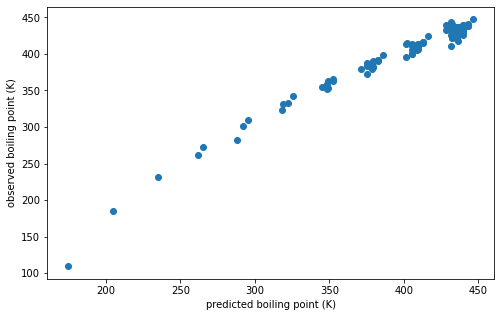

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.471e+05
Date:                Tue, 25 Aug 2020   Prob (F-statistic):                   1.36e-161
Time:                        18:16:36   Log-Likelihood:                         -384.42
No. Observations:                 102   AIC:                                      770.8
Df Residuals:                     101   BIC:                                      773.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [39]:
pred_bp = model.fittedvalues.copy()       # use our model to create a set of predicted bp's
fig, ax = plt.subplots(figsize=(8, 5))
lmod = sm.OLS(pred_bp, df.BP_K)           # linear regression of observed vs predicted bp's
res = lmod.fit()                          # run fitting
plt.scatter(pred_bp, df.BP_K)             # plot of of observed vs predicted bp's
plt.ylabel('observed boiling point (K)')
plt.xlabel('predicted boiling point (K)')
plt.show()
print(res.summary())                      # print linear regression stats summary

In [40]:
# TEST MOLECULE: n-decane
test_smiles = "CCCCCCCCCC"                  
test_mol = Chem.MolFromSmiles(test_smiles)             
test_slogp = slogp(test_mol)     
test_bondcount = bondcount(test_mol)        
test_fragcom = fragcom(test_mol)
test_topod = topod(test_mol)
# TEST MODEL
PredictedBP = -5.5319 * test_slogp + 30.5968 * test_bondcount - 63.5549 * test_fragcom + 4.2102 * test_topod + 55.3154
print("Predicted BP (K):", PredictedBP)
print("Experimental BP (K): 447.2")

Predicted BP (K): 446.7731107
Experimental BP (K): 447.2
